In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from surprise import SVD, Dataset, Reader

### Load data

In [22]:
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df.head()

,Runner ID,First Name,Surname,Nat.,Gender,Age,Age Group,Cat,YOB,Race Count,...,Cat. Rank,Finish Percentage,Performance Ratio,Distance/Time,Distance KM,Terrain,Time Seconds Finish,Distance Finish,Average Speed,Avg.Speed km/h
0,146799,David,Papineau,CAN,M,42.0,40-49,M40,1968.0,0,...,1.0,0.02,1.000000,50km,50.0,road,13911.0,NaN,278.22,12.939
1,35382,Hassan,Lotfi-Pour,CAN,M,42.0,40-49,M40,1968.0,0,...,2.0,0.04,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
2,11991,Ryne,Melcher,CAN,M,31.0,30-39,M23,1979.0,0,...,1.0,0.05,0.985827,50km,50.0,road,14111.0,NaN,282.22,12.756
3,37142,Gary,Robbins,CAN,M,34.0,30-39,M23,1976.0,0,...,2.0,0.07,0.966377,50km,50.0,road,14395.0,NaN,287.90,12.504
4,746071,Rian,O'Maol Chonaire,CAN,M,33.0,30-39,M23,1977.0,0,...,3.0,0.09,0.920040,50km,50.0,road,15120.0,NaN,302.40,11.905


In [125]:
df_clean = df[df['Event Type']=='Distance']

In [24]:
df_clean.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h'],
      dtype='object')

### Race difficulty weighting

In [77]:
def aggregate_by_event(df):
    agg_data = df.groupby('Event ID').agg({
        'Distance KM': 'first',
        'Elevation Gain': 'first',
        'Terrain': 'first',
        'Male Finishers': 'first',
        'Female Finishers': 'first',
        'Total Finishers': 'first',
        'Time Seconds Winner': 'first',
        'Time Seconds Finish': 'mean'
    }).reset_index()
    
    # Calculate average time
    agg_data['Average Time Seconds'] = agg_data['Time Seconds Finish']
    
    # Calculate winner and average pace
    agg_data['Winner Pace'] = agg_data['Time Seconds Winner'] / 60 / agg_data['Distance KM']
    agg_data['Average Pace'] = agg_data['Average Time Seconds'] / 60 / agg_data['Distance KM']
    agg_data['Gender Ratio'] = agg_data['Male Finishers'] / agg_data['Total Finishers']
    
    return agg_data

# Apply aggregation
df_event = aggregate_by_event(df_clean)

In [76]:
def sigmoid_normalize(x, midpoint, steepness=1):
    return 1 / (1 + np.exp(-steepness * (x - midpoint)))

def calculate_race_difficulty(df, weights):
    # Normalize factors
    distance_factor = sigmoid_normalize(df['Distance KM'], midpoint=100, steepness=0.05)
    elevation_factor = sigmoid_normalize(df['Elevation Gain'], midpoint=2500, steepness=0.001)
    terrain_factor = {'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5}[df['Terrain']]
    finishers_factor = max(1 - (df['Total Finishers'] / 1000), 0.5)
    gender_factor = df['Gender Ratio']
    
    # Calculate difficulty score using provided weights
    difficulty_score = (
        distance_factor * weights['distance'] +
        elevation_factor * weights['elevation'] +
        terrain_factor * weights['terrain'] +
        finishers_factor * weights['finishers'] +
        gender_factor * weights['gender']
    )
    
    return difficulty_score


In [96]:
weights = {
    'distance': 0.3,
    'elevation': 0.3,
    'terrain': 0.2,
    'finishers': 0.1,
    'gender': 0.1
}

df_event['Race Difficulty Score'] = df_event.apply(calculate_race_difficulty, weights=weights, axis=1)

In [97]:
df_event.head()

,Event ID,Distance KM,Elevation Gain,Terrain,Male Finishers,Female Finishers,Total Finishers,Time Seconds Winner,Time Seconds Finish,Average Time Seconds,Winner Pace,Average Pace,Gender Ratio,Race Difficulty Score
0,293,60.0,1350.0,trail,308,137,445,17488.0,30082.822472,30082.822472,4.857778,8.356340,0.692135,0.363408
1,305,50.0,NaN,road,121,19,140,14508.0,24248.064286,24248.064286,4.836000,8.082688,0.864286,NaN
2,312,50.0,2300.0,trail,57,22,79,21621.0,29206.898734,29206.898734,7.207000,9.735633,0.721519,0.449907
3,348,50.0,NaN,trail,94,40,134,16099.0,26751.828358,26751.828358,5.366333,8.917276,0.701493,NaN
4,352,50.0,NaN,trail,52,22,74,12073.0,20082.621622,20082.621622,4.024333,6.694207,0.702703,NaN


In [80]:
# Remove events with missing elevation data
agg_df_filtered = df_event.dropna()

print(f"Original number of events: {len(df_event)}")
print(f"Number of events with elevation data: {len(agg_df_filtered)}")
print(f"Number of events removed: {len(df_event) - len(agg_df_filtered)}")

Original number of events: 63097
Number of events with elevation data: 25138
Number of events removed: 37959


In [118]:
# Initial weights
initial_weights = {
    'distance': -0.3,
    'elevation': -0.3,
    'terrain': -0.2,
    'finishers': -0.1
}

# Calculate initial difficulty scores
agg_df_filtered['Race Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, initial_weights), axis=1)

def optimize_difficulty_score(df):
    # Prepare features
    X = df[['Distance KM', 'Elevation Gain', 'Total Finishers']]
    X['Terrain'] = df['Terrain'].map({'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5})
    
    # Normalize features
    X['Distance KM'] = sigmoid_normalize(X['Distance KM'], midpoint=100, steepness=0.05)
    X['Elevation Gain'] = sigmoid_normalize(X['Elevation Gain'], midpoint=2500, steepness=0.001)
    X['Total Finishers'] = sigmoid_normalize(X['Total Finishers'], midpoint=500, steepness=0.01)
    
    # Use a combination of winner pace and average pace as the target
    y = 1 / (0.7 * df['Winner Pace'] + 0.3 * df['Average Pace'])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    # Get optimized weights
    weights = {
        'distance': model.coef_[0],
        'elevation': model.coef_[1],
        'finishers': model.coef_[2],
        'terrain': model.coef_[3]
    }
    print("Optimized weights:", weights)
    
    return weights

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/3943947470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtered['Race Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, initial_weights), axis=1)


In [119]:
# Optimize weights
optimized_weights = optimize_difficulty_score(agg_df_filtered)

# Recalculate difficulty scores with optimized weights
agg_df_filtered['Optimized Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, optimized_weights), axis=1)

# Compare correlation
baseline_difficulty = 1 / (0.7 * agg_df_filtered['Winner Pace'] + 0.3 * agg_df_filtered['Average Pace'])
initial_correlation = agg_df_filtered['Race Difficulty Score'].corr(baseline_difficulty)
optimized_correlation = agg_df_filtered['Optimized Difficulty Score'].corr(baseline_difficulty)

print(f"Initial correlation: {initial_correlation}")
print(f"Optimized correlation: {optimized_correlation}")

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/3943947470.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Terrain'] = df['Terrain'].map({'road': 0.6, 'track': 0.4, 'trail': 1.0, 'other': 0.5})
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/3943947470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Distance KM'] = sigmoid_normalize(X['Distance KM'], midpoint=100, steepness=0.05)
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/3943947470.py:

Mean Squared Error: 0.00044899858480238955
Optimized weights: {'distance': -0.011092803665033768, 'elevation': -0.06620066021641068, 'finishers': 0.019567415967816974, 'terrain': -0.02173649321262225}
Initial correlation: 0.6786863109632616
Optimized correlation: 0.6922087650670146


/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/788683319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_df_filtered['Optimized Difficulty Score'] = agg_df_filtered.apply(lambda row: calculate_race_difficulty(row, optimized_weights), axis=1)


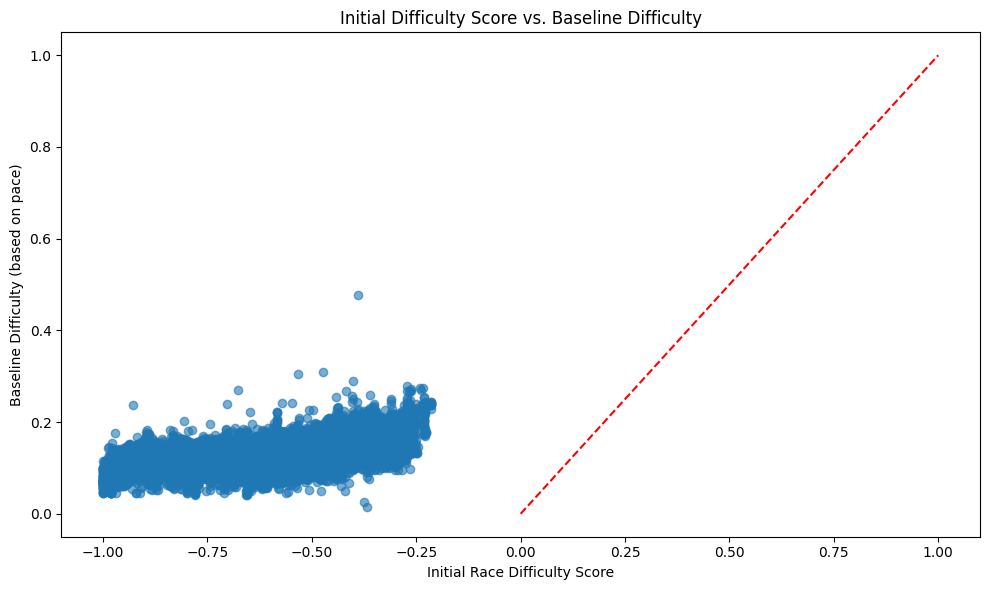

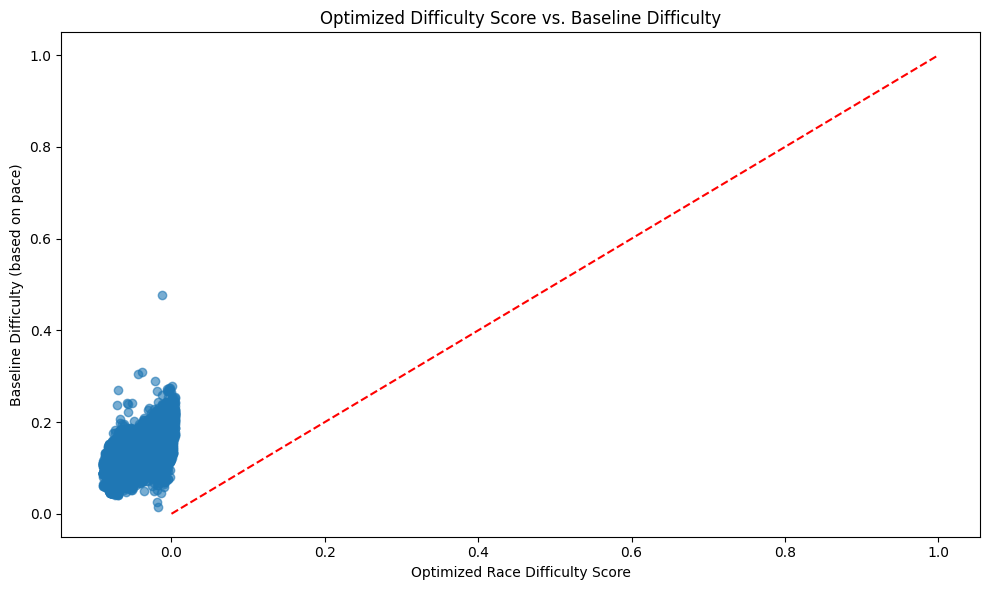

/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1436151058.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=agg_df_filtered['Race Difficulty Score'], shade=True, label='Initial Score')
/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1436151058.py:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=agg_df_filtered['Optimized Difficulty Score'], shade=True, label='Optimized Score')


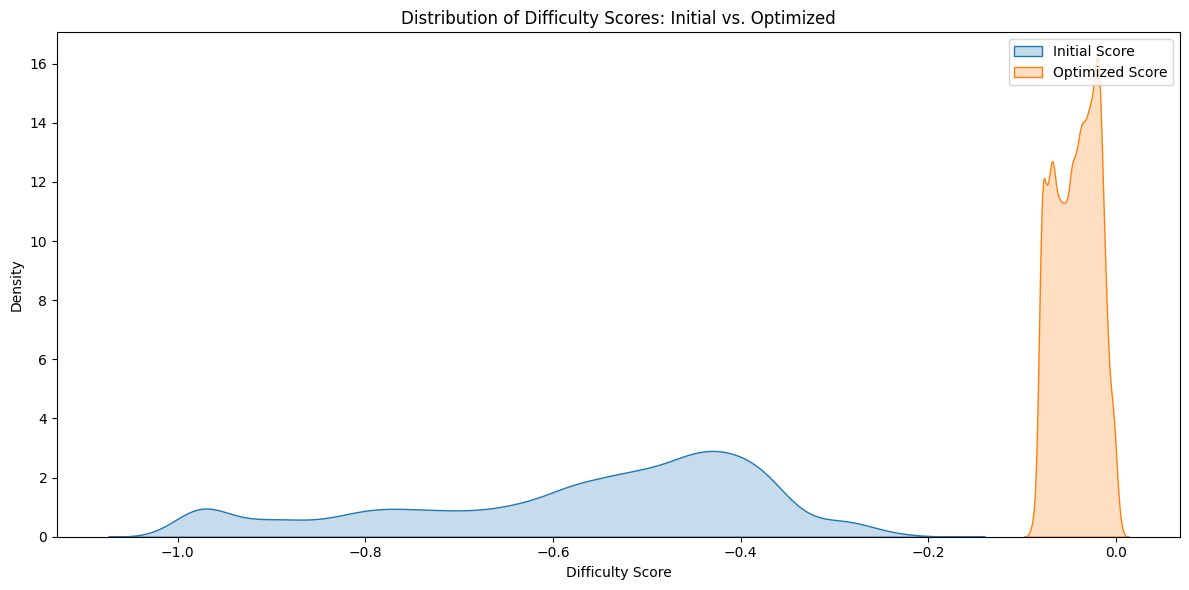

<Figure size 1000x600 with 0 Axes>

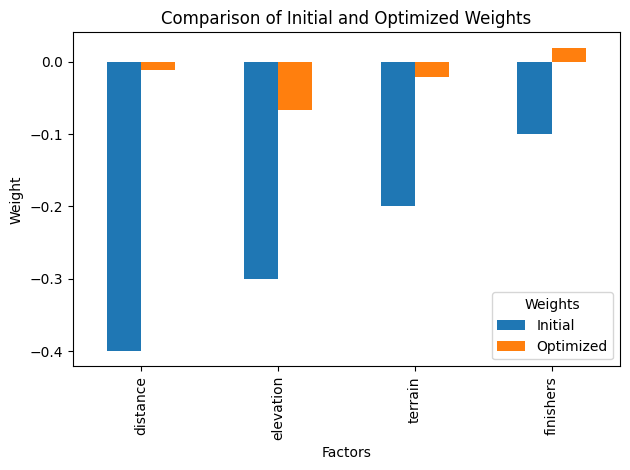

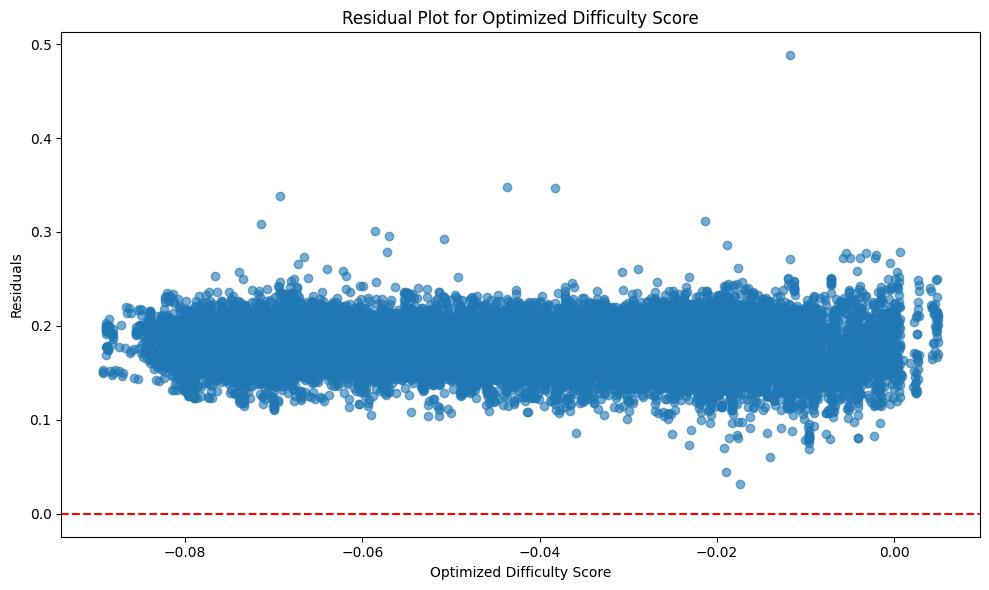

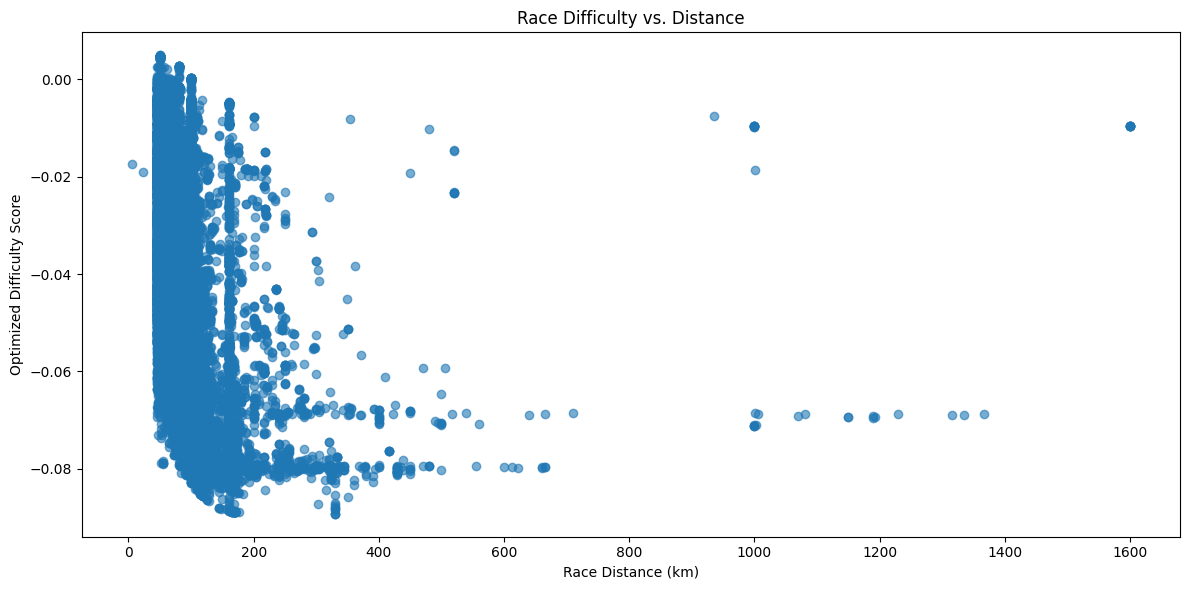

Summary Statistics for Optimized Difficulty Score:
count    25138.000000
mean        -0.042886
std          0.022427
min         -0.089246
25%         -0.062458
50%         -0.041450
75%         -0.023713
max          0.004951
Name: Optimized Difficulty Score, dtype: float64

Correlation Matrix:
                            Distance KM  Elevation Gain  Total Finishers  \
Distance KM                    1.000000        0.478866        -0.089243   
Elevation Gain                 0.478866        1.000000        -0.000372   
Total Finishers               -0.089243       -0.000372         1.000000   
Optimized Difficulty Score    -0.377815       -0.804910        -0.098306   

                            Optimized Difficulty Score  
Distance KM                                  -0.377815  
Elevation Gain                               -0.804910  
Total Finishers                              -0.098306  
Optimized Difficulty Score                    1.000000  


/var/folders/ss/kjxldrfs36qgygzmg25sqy100000gn/T/ipykernel_24214/1436151058.py:78: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = agg_df_filtered[['Distance KM', 'Elevation Gain', 'Total Finishers', 'Terrain', 'Optimized Difficulty Score']].corr()


In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
#plt.style.use('seaborn')

# 1. Scatter plot of initial difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Race Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Initial Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Initial Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 2. Scatter plot of optimized difficulty score vs. baseline difficulty
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], baseline_difficulty, alpha=0.6)
plt.xlabel('Optimized Race Difficulty Score')
plt.ylabel('Baseline Difficulty (based on pace)')
plt.title('Optimized Difficulty Score vs. Baseline Difficulty')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
plt.tight_layout()
plt.show()

# 3. Distribution of difficulty scores before and after optimization
plt.figure(figsize=(12, 6))
sns.kdeplot(data=agg_df_filtered['Race Difficulty Score'], shade=True, label='Initial Score')
sns.kdeplot(data=agg_df_filtered['Optimized Difficulty Score'], shade=True, label='Optimized Score')
plt.xlabel('Difficulty Score')
plt.ylabel('Density')
plt.title('Distribution of Difficulty Scores: Initial vs. Optimized')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Bar plot of initial and optimized weights
weights_df = pd.DataFrame({
    'Initial': initial_weights,
    'Optimized': optimized_weights
})

plt.figure(figsize=(10, 6))
weights_df.plot(kind='bar')
plt.title('Comparison of Initial and Optimized Weights')
plt.xlabel('Factors')
plt.ylabel('Weight')
plt.legend(title='Weights')
plt.tight_layout()
plt.show()

# 5. Residual plot for the optimized model
residuals = baseline_difficulty - agg_df_filtered['Optimized Difficulty Score']
plt.figure(figsize=(10, 6))
plt.scatter(agg_df_filtered['Optimized Difficulty Score'], residuals, alpha=0.6)
plt.xlabel('Optimized Difficulty Score')
plt.ylabel('Residuals')
plt.title('Residual Plot for Optimized Difficulty Score')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# 6. Difficulty score vs. race distance
plt.figure(figsize=(12, 6))
plt.scatter(agg_df_filtered['Distance KM'], agg_df_filtered['Optimized Difficulty Score'], alpha=0.6)
plt.xlabel('Race Distance (km)')
plt.ylabel('Optimized Difficulty Score')
plt.title('Race Difficulty vs. Distance')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Optimized Difficulty Score:")
print(agg_df_filtered['Optimized Difficulty Score'].describe())

# Print correlation matrix
correlation_matrix = agg_df_filtered[['Distance KM', 'Elevation Gain', 'Total Finishers', 'Optimized Difficulty Score']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [99]:
optimized_weights = weights_df['Optimized'].to_dict()
df_event['Optimised Difficulty Score'] = df_event.apply(calculate_race_difficulty, weights=optimized_weights, axis=1)
df_event.head()

,Event ID,Distance KM,Elevation Gain,Terrain,Male Finishers,Female Finishers,Total Finishers,Time Seconds Winner,Time Seconds Finish,Average Time Seconds,Winner Pace,Average Pace,Gender Ratio,Race Difficulty Score,Optimised Difficulty Score
0,293,60.0,1350.0,trail,308,137,445,17488.0,30082.822472,30082.822472,4.857778,8.356340,0.692135,0.363408,-0.028119
1,305,50.0,NaN,road,121,19,140,14508.0,24248.064286,24248.064286,4.836000,8.082688,0.864286,NaN,NaN
2,312,50.0,2300.0,trail,57,22,79,21621.0,29206.898734,29206.898734,7.207000,9.735633,0.721519,0.449907,-0.034358
3,348,50.0,NaN,trail,94,40,134,16099.0,26751.828358,26751.828358,5.366333,8.917276,0.701493,NaN,NaN
4,352,50.0,NaN,trail,52,22,74,12073.0,20082.621622,20082.621622,4.024333,6.694207,0.702703,NaN,NaN


Correlation between original and optimized difficulty scores:
-0.9022463637322967


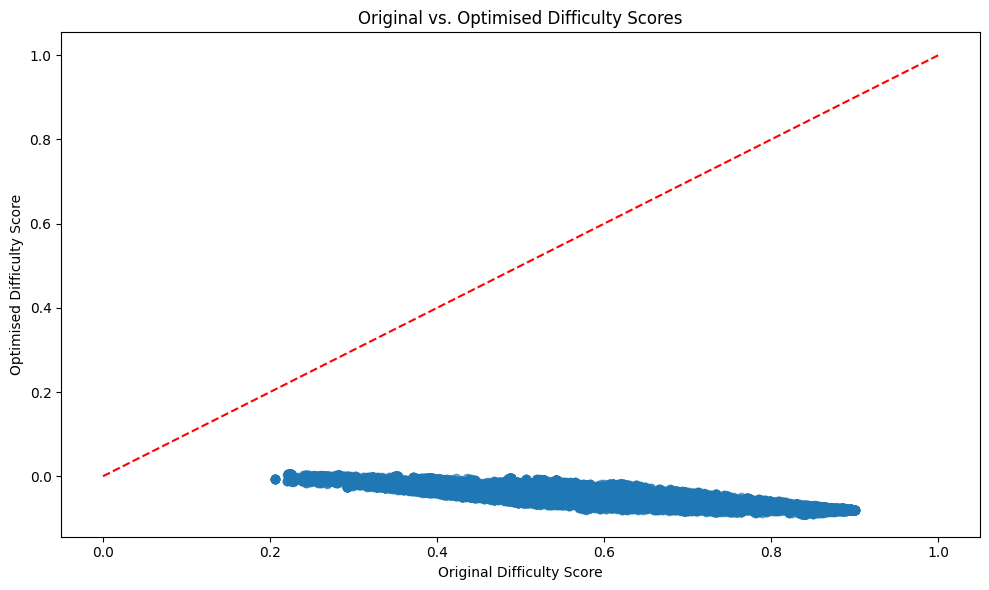


Summary statistics of Optimised Difficulty Scores:
count    25151.000000
mean        -0.042887
std          0.022425
min         -0.089246
25%         -0.062458
50%         -0.041450
75%         -0.023714
max          0.004951
Name: Optimised Difficulty Score, dtype: float64


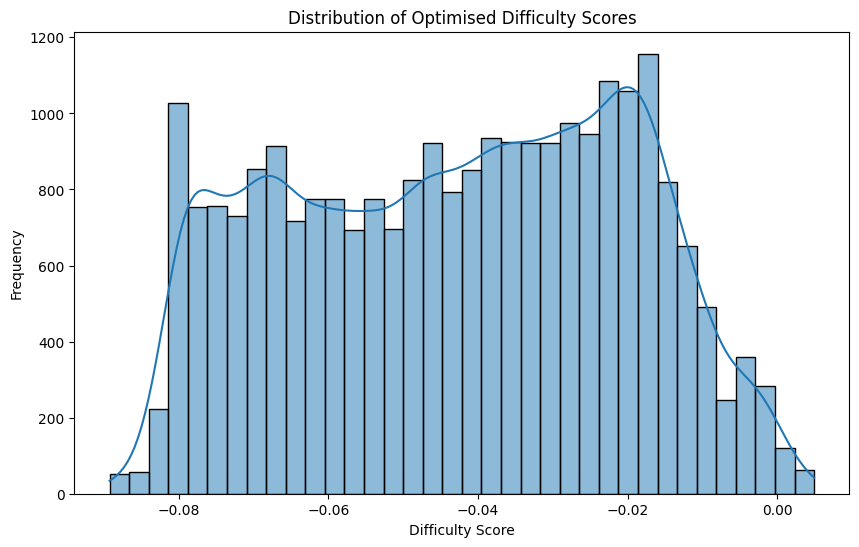

In [100]:
if 'Race Difficulty Score' in df_event.columns:
    print("Correlation between original and optimized difficulty scores:")
    print(df_event['Race Difficulty Score'].corr(df_event['Optimised Difficulty Score']))

    # Visualize the difference
    plt.figure(figsize=(10, 6))
    plt.scatter(df_event['Race Difficulty Score'], df_event['Optimised Difficulty Score'], alpha=0.6)
    plt.xlabel('Original Difficulty Score')
    plt.ylabel('Optimised Difficulty Score')
    plt.title('Original vs. Optimised Difficulty Scores')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Add a diagonal line for reference
    plt.tight_layout()
    plt.show()

# Print summary statistics of the new difficulty scores
print("\nSummary statistics of Optimised Difficulty Scores:")
print(df_event['Optimised Difficulty Score'].describe())

# Visualize the distribution of new difficulty scores
plt.figure(figsize=(10, 6))
sns.histplot(df_event['Optimised Difficulty Score'], kde=True)
plt.title('Distribution of Optimised Difficulty Scores')
plt.xlabel('Difficulty Score')
plt.ylabel('Frequency')
plt.show()

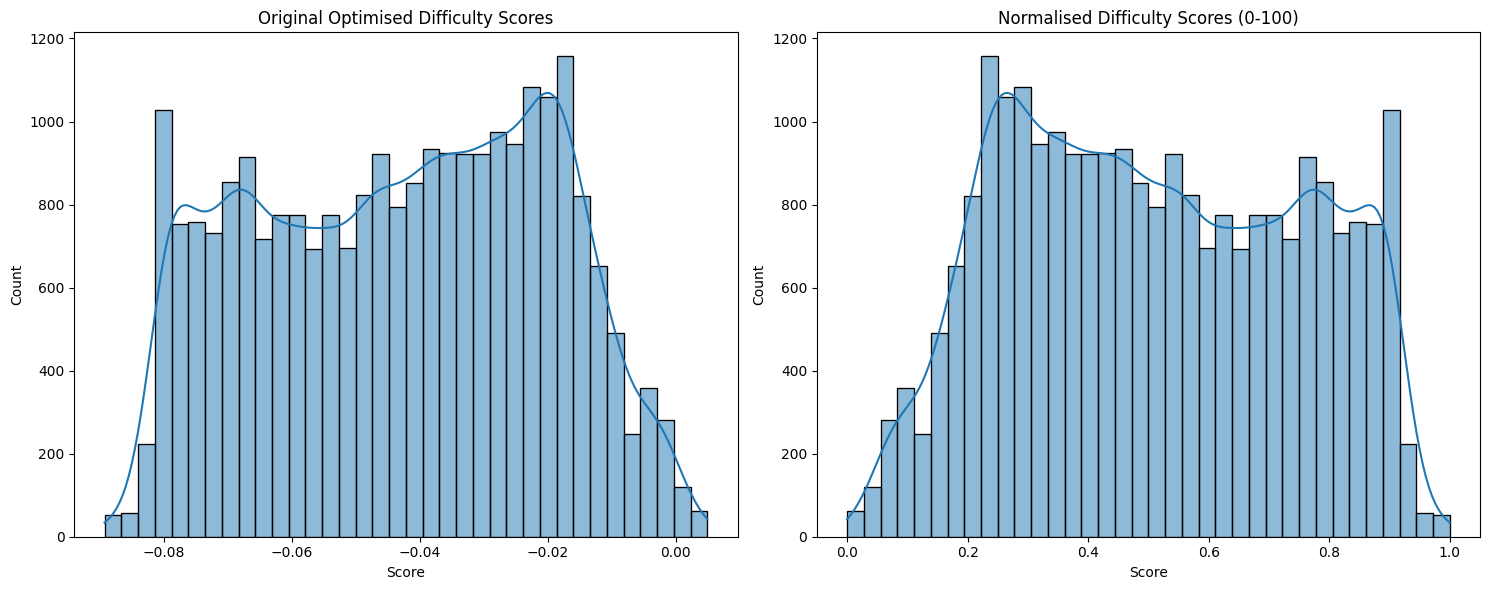


Summary statistics for Original Optimised Difficulty Score:
count    25151.000000
mean        -0.042887
std          0.022425
min         -0.089246
25%         -0.062458
50%         -0.041450
75%         -0.023714
max          0.004951
Name: Optimised Difficulty Score, dtype: float64

Summary statistics for Normalised Difficulty Score:
count    25151.000000
mean         0.507853
std          0.238069
min          0.000000
25%          0.304311
50%          0.492594
75%          0.715611
max          1.000000
Name: Normalised Difficulty Score, dtype: float64


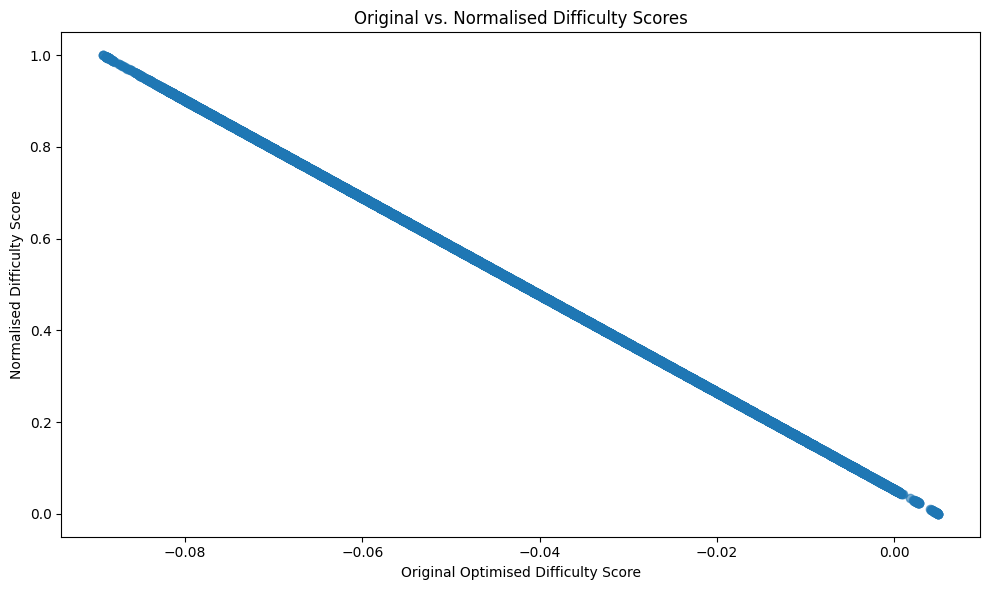


Top 10 Most Difficult Races:
       Event ID  Normalised Difficulty Score  Distance KM  Elevation Gain
29341     51130                     1.000000        330.0         24000.0
31257     53517                     1.000000        330.0         24000.0
51982     91890                     1.000000        330.0         24000.0
58215    100794                     0.996995        176.0          9900.0
7797      20531                     0.996479        172.0          9996.0
39194     67456                     0.996425        171.0         10300.0
23595     43300                     0.996324        171.0         10000.0
30782     52913                     0.996324        171.0         10000.0
11294     26178                     0.996161        170.0         10000.0
14390     30659                     0.996161        170.0         10000.0

Bottom 10 Least Difficult Races:
       Event ID  Normalised Difficulty Score  Distance KM  Elevation Gain
21819     40832                     0.000000    

In [121]:
def invert_and_normalize(scores, scale_to_100=False):
    # Invert the scores
    inverted_scores = -scores
    
    # Apply min-max normalization
    normalised = (inverted_scores - inverted_scores.min()) / (inverted_scores.max() - inverted_scores.min())
    
    # Scale to 0-100 range if requested
    if scale_to_100:
        normalised = normalised * 100
    
    return normalised

# Apply the inversion and normalization
df_event['Normalised Difficulty Score'] = invert_and_normalize(df_event['Optimised Difficulty Score'])

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original Optimised Difficulty Scores
sns.histplot(df_event['Optimised Difficulty Score'], kde=True, ax=ax1)
ax1.set_title('Original Optimised Difficulty Scores')
ax1.set_xlabel('Score')

# Normalised Difficulty Scores
sns.histplot(df_event['Normalised Difficulty Score'], kde=True, ax=ax2)
ax2.set_title('Normalised Difficulty Scores (0-100)')
ax2.set_xlabel('Score')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary statistics for Original Optimised Difficulty Score:")
print(df_event['Optimised Difficulty Score'].describe())

print("\nSummary statistics for Normalised Difficulty Score:")
print(df_event['Normalised Difficulty Score'].describe())

# Scatter plot to compare original and normalised scores
plt.figure(figsize=(10, 6))
plt.scatter(df_event['Optimised Difficulty Score'], df_event['Normalised Difficulty Score'], alpha=0.6)
plt.xlabel('Original Optimised Difficulty Score')
plt.ylabel('Normalised Difficulty Score')
plt.title('Original vs. Normalised Difficulty Scores')
plt.tight_layout()
plt.show()

# Display the top 10 most difficult races
print("\nTop 10 Most Difficult Races:")
top_10 = df_event.nlargest(10, 'Normalised Difficulty Score')[['Event ID', 'Normalised Difficulty Score', 'Distance KM', 'Elevation Gain']]
print(top_10)

# Display the bottom 10 least difficult races
print("\nBottom 10 Least Difficult Races:")
bottom_10 = df_event.nsmallest(10, 'Normalised Difficulty Score')[['Event ID', 'Normalised Difficulty Score', 'Distance KM', 'Elevation Gain']]
print(bottom_10)

In [130]:
df_clean = df.merge(df_event[['Event ID', 'Normalised Difficulty Score']], on='Event ID', how='left')
df_clean['Inverse Time'] = 1 / (df_clean['Time Seconds Finish'] / 60)
df_clean['Weighted Performance'] = df_clean['Time Seconds Finish'] * df_clean['Normalised Difficulty Score']


In [134]:
df_clean.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h', 'Normalised Difficulty Score', 'Inverse Time',
       'Weighted Performance'],
      dtype='object')

In [139]:
df_clean.sample(10)

### Random Forest

In [30]:
features = df_clean.groupby('Runner ID').agg(
    average_time=('Time Seconds Finish', 'mean'),
    min_time=('Time Seconds Finish', 'min'),
    max_time=('Time Seconds Finish', 'max'),
    count_races=('Time Seconds Finish', 'count'),
    avg_percentile=('Finish Percentage', 'mean'),
    max_percentile=('Finish Percentage', 'max'),
    min_percentile=('Finish Percentage', 'min'),
    avg_speed=('Average Speed', 'mean'),
    max_speed=('Average Speed', 'max'),
    min_speed=('Average Speed', 'min'),
    race_difficulty=('Normalised Difficulty Score', 'mean'),
    weighted_performance=('Weighted Performance', 'mean')
).reset_index()

features.head()

,Runner ID,average_time,min_time,max_time,count_races,avg_percentile,max_percentile,min_percentile,avg_speed,max_speed,min_speed,race_difficulty,weighted_performance
0,1,26940.000000,26940.0,26940.0,1,0.840000,0.84,0.84,585.652174,585.652174,585.652174,0.534450,0.279723
1,33,54590.628571,22920.0,631680.0,35,0.668286,0.94,0.38,561.012006,874.555556,469.919355,0.722541,0.480819
2,34,25379.500000,14962.0,35797.0,2,0.435000,0.71,0.16,420.809394,542.378788,299.240000,0.545250,0.363460
3,47,34743.000000,23129.0,46357.0,2,0.260000,0.31,0.21,463.075000,463.570000,462.580000,0.678175,0.531617
4,69,32062.000000,16772.0,45183.0,6,0.525000,0.89,0.38,416.089314,664.455882,335.440000,0.653817,0.433770


In [152]:
data = df_clean

# Function to aggregate runner data
def aggregate_runner_data(group):
    return pd.Series({
        'Avg_Performance_Ratio': group['Performance Ratio'].mean(),
        'Avg_Finish_Percentage': group['Finish Percentage'].mean(),
        'Total_Races': len(group),
        'Total_Distance': group['Distance KM'].sum(),
        'Preferred_Terrain': group['Terrain'].mode().iloc[0],
        'Avg_Normalised_Difficulty': group['Normalised Difficulty Score'].mean(),
        'Avg_Speed': group['Avg.Speed km/h'].mean()
    })

# Aggregate runner data
runner_data = data.groupby('Runner ID').apply(aggregate_runner_data).reset_index()

# Merge aggregated data back with original data
merged_data = pd.merge(data, runner_data, on='Runner ID', suffixes=('', '_history'))

# Select features and target
features = [
    'Distance KM', 'Elevation Gain', 'Terrain', 'Total Finishers', 
    'Normalised Difficulty Score', 'Avg_Performance_Ratio', 'Avg_Finish_Percentage',
    'Total_Races', 'Total_Distance', 'Preferred_Terrain', 'Avg_Normalised_Difficulty',
    'Avg_Speed', 'Age', 'Gender'
]
target = 'Time Seconds Finish'

# Remove rows with NaN values in features or target
merged_data_clean = merged_data.dropna(subset=features + [target])

# Prepare the features and target
X = merged_data_clean[features]
y = merged_data_clean[target]

# Handle missing values
X = X.fillna({
    'Avg_Performance_Ratio': X['Avg_Performance_Ratio'].mean(),
    'Avg_Finish_Percentage': X['Avg_Finish_Percentage'].mean(),
    'Total_Races': 0,
    'Total_Distance': 0,
    'Preferred_Terrain': 'Unknown',
    'Avg_Normalised_Difficulty': X['Avg_Normalised_Difficulty'].mean(),
    'Avg_Speed': X['Avg_Speed'].mean(),
    'Age': X['Age'].median()
})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = [
    'Distance KM', 'Elevation Gain', 'Total Finishers', 'Normalised Difficulty Score',
    'Avg_Performance_Ratio', 'Avg_Finish_Percentage', 'Total_Races', 'Total_Distance',
    'Avg_Normalised_Difficulty', 'Avg_Speed', 'Age'
]
categorical_features = ['Terrain', 'Preferred_Terrain', 'Gender']

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with preprocessor and random forest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [153]:
# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 33833886.29743196
R-squared Score: 0.9785791897340357


In [159]:
feature_names = (numeric_features + 
                 [f"{feature}_{category}" for feature, categories in 
                  zip(categorical_features, 
                      rf_model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .categories_) 
                  for category in categories[1:]])

# Get feature importances
importances = rf_model.named_steps['regressor'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Distance KM (0.811519)
2. Elevation Gain (0.063195)
3. Avg_Speed (0.046849)
4. Avg_Finish_Percentage (0.021861)
5. Normalised Difficulty Score (0.019702)
6. Avg_Performance_Ratio (0.010179)
7. Total Finishers (0.006772)
8. Avg_Normalised_Difficulty (0.004913)
9. Terrain_trail (0.004841)
10. Terrain_road (0.002827)
11. Age (0.002793)
12. Total_Distance (0.002413)
13. Total_Races (0.001590)
14. Gender_M (0.000238)


In [160]:
def generate_runner_history(data, runner_id):
    # Filter data for the specific runner
    runner_data = data[data['Runner ID'] == runner_id]
    
    if runner_data.empty:
        print(f"No data found for Runner ID: {runner_id}")
        return None
    
    # Calculate aggregate statistics
    history = {
        'avg_performance_ratio': runner_data['Performance Ratio'].mean(),
        'avg_finish_percentage': runner_data['Finish Percentage'].mean(),
        'total_races': len(runner_data),
        'total_distance': runner_data['Distance KM'].sum(),
        'preferred_terrain': runner_data['Terrain'].mode().iloc[0] if not runner_data['Terrain'].mode().empty else 'Unknown',
        'avg_normalised_difficulty': runner_data['Normalised Difficulty Score'].mean(),
        'avg_speed': runner_data['Avg.Speed km/h'].mean(),
        'age': runner_data['Age'].iloc[-1] if 'Age' in runner_data.columns else np.nan,
        'gender': runner_data['Gender'].iloc[0] if 'Gender' in runner_data.columns else 'Unknown'
    }
    
    # Additional statistics
    history['best_performance_ratio'] = runner_data['Performance Ratio'].max()
    history['worst_performance_ratio'] = runner_data['Performance Ratio'].min()
    history['avg_elevation_gain_per_km'] = runner_data['Elevation Gain'].sum() / history['total_distance']
    history['favorite_distance'] = runner_data['Distance KM'].mode().iloc[0]
    history['avg_rank_percentage'] = runner_data['Rank'].mean() / runner_data['Total Finishers'].mean()
    
    # Calculate improvement trend (using last 5 races if available)
    last_5_races = runner_data.sort_values('Date').tail(5)
    if len(last_5_races) >= 2:
        performance_trend = np.polyfit(range(len(last_5_races)), last_5_races['Performance Ratio'], 1)[0]
        history['performance_trend'] = performance_trend
    else:
        history['performance_trend'] = 0
    
    # Handle potential NaN values
    for key, value in history.items():
        if pd.isna(value):
            if key in ['age', 'total_races', 'total_distance']:
                history[key] = 0
            elif key in ['avg_performance_ratio', 'avg_finish_percentage', 'avg_normalised_difficulty', 'avg_speed']:
                history[key] = data[key.replace('avg_', '')].mean()
            else:
                history[key] = 'Unknown'
    
    return history

# Example usage:
# Assuming 'data' is your DataFrame containing all race results
# runner_id = 12345  # Replace with an actual Runner ID from your dataset
# runner_history = generate_runner_history(data, runner_id)
# print(runner_history)

In [173]:
runner_history = generate_runner_history(merged_data, '1393329')
print(runner_history)

{'avg_performance_ratio': 0.7589010976531506, 'avg_finish_percentage': 0.1792307692307692, 'total_races': 13, 'total_distance': 1043.0, 'preferred_terrain': 'trail', 'avg_normalised_difficulty': 0.6271487184357281, 'avg_speed': 7.361230769230769, 'age': 39.0, 'gender': 'F', 'best_performance_ratio': 0.8581997161578645, 'worst_performance_ratio': 0.6545534595455007, 'avg_elevation_gain_per_km': 36.61649089165868, 'favorite_distance': 50.0, 'avg_rank_percentage': 0.1422660725652451, 'performance_trend': -0.021304256960320254}


In [154]:
# Function to make predictions
def predict_finish_time(runner_history, race_details):
    input_data = pd.DataFrame({
        'Distance KM': [race_details['distance']],
        'Elevation Gain': [race_details['elevation_gain']],
        'Terrain': [race_details['terrain']],
        'Total Finishers': [race_details['total_finishers']],
        'Normalised Difficulty Score': [race_details['difficulty_score']],
        'Avg_Performance_Ratio': [runner_history['avg_performance_ratio']],
        'Avg_Finish_Percentage': [runner_history['avg_finish_percentage']],
        'Total_Races': [runner_history['total_races']],
        'Total_Distance': [runner_history['total_distance']],
        'Preferred_Terrain': [runner_history['preferred_terrain']],
        'Avg_Normalised_Difficulty': [runner_history['avg_normalised_difficulty']],
        'Avg_Speed': [runner_history['avg_speed']],
        'Age': [runner_history['age']],
        'Gender': [runner_history['gender']]
    })
    prediction = rf_model.predict(input_data)
    return prediction[0]

In [174]:
import datetime

race_details = {
    'distance': 101,
    'elevation_gain': 6050,
    'terrain': 'trail',
    'total_finishers': 1636,
    'difficulty_score': 0.7
}

example_prediction = predict_finish_time(runner_history, race_details)
example_prediction = str(datetime.timedelta(seconds=example_prediction))
print(f"Predicted finish time: {example_prediction}")

Predicted finish time: 14:08:39.120000
